In [1]:
#| echo: false
import copy
import pathlib
import warnings
import logging
logging.basicConfig(level=logging.CRITICAL)

import astropy.units as u
import distributed
import fiasco
import fiasco.io
import matplotlib.pyplot as plt
import ndcube
import numpy as np

fiasco.log.setLevel(logging.CRITICAL)

from astropy.modeling import CompoundModel
from astropy.modeling.models import Gaussian1D, Lorentz1D, Polynomial1D
from astropy.modeling.fitting import LMLSQFitter, TRFLSQFitter
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval, quantity_support
from astropy.wcs.utils import wcs_to_celestial_frame
from IPython.display import Markdown
from synthesizAR.atomic.idl import read_spectral_table, write_spectral_table
from tabulate import tabulate

from mocksipipeline.instrument.configuration import moxsi_cdr_spectrogram_slot
from mocksipipeline.modeling import convolve_with_response, project_spectral_cube
from mocksipipeline.util import read_cube_with_xarray, read_data_cube, build_moxsi_collection

In [2]:
#| echo: false

# Define some functions we will use later

def get_abundance_ratio(el_1,
                        el_2,
                        temperature=1*u.MK,
                        coronal_abundance_filename='sun_coronal_1992_feldman_ext',
                        photospheric_abundance_filename='sun_photospheric_2015_scott'):
    el_1 = fiasco.Element(el_1,temperature)
    el_2 = fiasco.Element(el_2,temperature)
    # coronal ratio
    el_1.abundance = coronal_abundance_filename
    el_2.abundance = coronal_abundance_filename
    ratio_c = el_1.abundance / el_2.abundance
    # photospheric ratio
    el_1.abundance = photospheric_abundance_filename
    el_2.abundance = photospheric_abundance_filename
    ratio_p = el_1.abundance / el_2.abundance
    return ratio_c / ratio_p


def compute_intensity(t_goft, goft, dem):
    t_dem = dem.axis_world_coords('temperature')[0]
    dem_interp = np.interp(t_goft, t_dem, dem.data)
    dem_interp = u.Quantity(dem_interp, dem_avg.unit)
    return (goft * dem_interp).sum() / (4*np.pi*u.steradian)


def get_1d_slot_spectra(collection, orders=None, cutout=None):
    if cutout is None:
        cutout = np.s_[:,:,:]
    if orders is None:
        orders = np.arange(-12,13,1)
    slot_cutouts = {f'spectrogram_slot_{i}': collection[f'spectrogram_slot_{i}'][cutout] for i in orders}
    slot_cutouts['all_components'] = collection['all_components'][cutout]
    slot_cutouts_rebin = {k: v.rebin((1, v.data.shape[1], 1), operation=np.sum).squeeze() for k, v in slot_cutouts.items()}
    return ndcube.NDCollection(slot_cutouts_rebin)


def get_first_order_intensity(filename, source_location, wavelength, cutout_sl):
    """
    Get intensity at a particular wavelength in first order
    """
    col = build_moxsi_collection(filename, all_components_sum=False)
    cutout = get_1d_slot_spectra(col, orders=[1,], cutout=cutout_sl)
    idx = cutout['spectrogram_slot_1'].wcs.world_to_array_index(
        source_location, 
        wavelength
    )
    return u.Quantity(
        cutout['spectrogram_slot_1'].data[idx],
        cutout['spectrogram_slot_1'].unit
    )


def fit_spectra(slot_spec, source_location, wavelength, model, window=[-20,20]):
    """
    1. Select relevant range out of reduced spectra
    2. Reduce spectra
    3. Construct model
    4. Fit model
    5. Return fitted model
    (optional) 6. Plot fitted model
    """
    idy,idx = slot_spec.wcs.world_to_array_index(source_location, wavelength)
    idx_sl = np.s_[idy, idx+window[0]:idx+window[1]]
    spec_sl = slot_spec[idx_sl]
    x_data = spec_sl.axis_world_coords(0)[0].Ty  # assumes dispersion is aligned in HPC latitude
    y_data = u.Quantity(spec_sl.data, spec_sl.unit)
    model_init = model.copy()
    if isinstance(model_initial, CompoundModel):
        for m in model_initial:
            m.amplitude = y_data[abs(window[0])]
    else:
        model_init.amplitude = y_data[abs(window[0])]
    bg = Polynomial1D(1,)
    model_init = model_init + bg
    fitter = TRFLSQFitter(calc_uncertainties=True)
    model_fit = fitter(model_init, x_data, y_data)
    return x_data, y_data, model_fit


In [3]:
#| echo: false

# Define some variables we will use later

temperature = 10**np.arange(5.5,7.5,0.01)*u.K
density = 1e9 * u.cm**(-3)
selected_elements = [
    'Fe',
    'Si',
    'Ne',
    'O',
]
selected_ions = [
    'Ne X',
    'Fe XVII',
    'O VII',
    'Si XII',
]
selected_transitions = {
    'Ne 10': 12.1321*u.AA,
    'Fe 17': 15.0129*u.AA,
    'O 7': 21.601*u.AA,
    'Si 12': 44.160*u.AA,
}

## Summary

- number: 15
- type: RFA
- category: Instrument systems
- name: SNR Calculations

### Request

Provide SNR calculations for full wavelength range for AR case. Demonstrate the abundance sensitivity.

### Comment

The SNR looked quite low for the portion of the detector shown for the AR case. Please demonstrate you have adequate SNR for abundance calculations.

## Selecting Line Pairs for Abundance Diagnostics

- Low-FIP elements: *enhanced at coronal abundances*
- High-FIP elements: *little change from coronal to photospheric abundances*
- **Goal: Estimate abundances by measuring ratios of high- and low-FIP lines**
- Requires:
    - Pairs of high- and low-FIP lines
    - With overlapping thermal sensitivity
    - That are sufficiently strong and
    - Have minimal blends

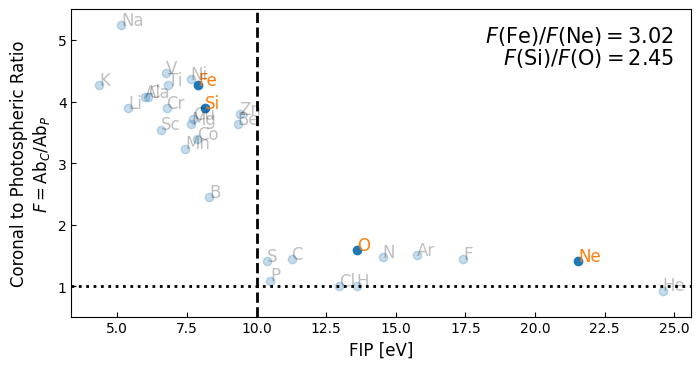

In [34]:
#| echo: false
#| fig-cap: "Coronal-to-photospheric abundance ratio or FIP ratio as function for first ionization potential (FIP) for all elements in CHIANTI."
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
with quantity_support():
    elements = fiasco.list_elements()
    for el in elements:
        el_coronal = fiasco.Element(el, 1*u.MK, abundance='sun_coronal_1992_feldman_ext')
        el_photo = fiasco.Element(el, 1*u.MK, abundance='sun_photospheric_2015_scott')
        ax.plot(el_coronal[0].ionization_potential.to('eV'),
                el_coronal.abundance/el_photo.abundance,
                marker='o',
                ls='',
                color='C0',
                alpha=1 if el in selected_elements else 0.25)
        #if el in selected_elements:
        ax.annotate(el_coronal.atomic_symbol,
                     (el_coronal[0].ionization_potential.to_value('eV'), el_coronal.abundance/el_photo.abundance,),
                     fontsize=12,
                     color='C1' if el_coronal.atomic_symbol in selected_elements else 'k',
                     alpha=1 if el_coronal.atomic_symbol in selected_elements else 0.25,
                    )
    ax.axvline(x=10, ls='--', color='k')
    #ax.axhline(y=4, ls=':', color='k')
    ax.axhline(y=1, ls=':', color='k')
    ax.set_ylabel('Coronal to Photospheric Ratio\n$F=\mathrm{Ab}_C/\mathrm{Ab}_P$')
    ax.set_xlabel('FIP [eV]')
    ax.set_ylim(0.5,5.5)
    ax.text(25,
            5.25,
            r'$F(\mathrm{Fe})/F(\mathrm{Ne})='+f"{get_abundance_ratio('Fe','Ne'):.02f}$",
            ha='right',
            va='top',
            fontsize=15)
    ax.text(25,
            4.9,
            r'$F(\mathrm{Si})/F(\mathrm{O})='+f"{get_abundance_ratio('Si','O'):.02f}$",
            ha='right',
            va='top',
            fontsize=15)
fig.savefig('rfa_figures/fip_plot.png')

In [5]:
#| echo: false
coronal_ions = fiasco.IonCollection(*[
    fiasco.Ion(name, temperature, abundance='sun_coronal_1992_feldman_ext') for name in selected_ions
])
photospheric_ions = fiasco.IonCollection(*[
    fiasco.Ion(name, temperature, abundance='sun_photospheric_2015_scott') for name in selected_ions
])

In [6]:
#| echo: false
goft_coronal = {}
goft_photospheric = {}
for ion_c,ion_p in zip(coronal_ions,photospheric_ions):
    goft_c = ion_c.contribution_function(density).squeeze()
    wavelengths = ion_c.transitions.wavelength[~ion_c.transitions.is_twophoton]
    idx = np.argmin(np.fabs(wavelengths - selected_transitions[ion_c.ion_name]))
    goft_coronal[ion_c.ion_name] = goft_c[:,idx]
    goft_photospheric[ion_p.ion_name] = ion_p.contribution_function(density).squeeze()[:,idx]

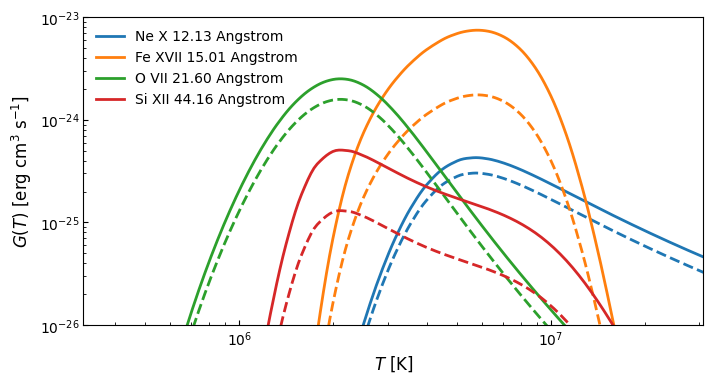

In [35]:
#| echo: false
#| fig-cap: "Contribution functions for the four selected diagnostic lines. These four lines represent pairs of high- and low-FIP elements with overlapping thermal sensitivity. The solid lines denote coronal abundances and the dashed lines denote photospheric abundances."
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
for ion in coronal_ions:
    l, = ax.plot(ion.temperature,
                 goft_coronal[ion.ion_name],
                 label=f'{ion.ion_name_roman} {selected_transitions[ion.ion_name]:.02f}')
    ax.plot(ion.temperature,
            goft_photospheric[ion.ion_name],
            color=l.get_color(),
            ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-26, 1e-23)
ax.set_xlim(ion.temperature[[0,-1]].value)
ax.set_xlabel(r'$T$ [K]')
ax.set_ylabel(r'$G(T)$ [erg cm$^{3}$ s$^{-1}$]')
ax.legend(frameon=False);
fig.savefig('rfa_figures/contribution_functions.png')

In [42]:
for k,v in goft_coronal.items():
    print(k,ion.temperature[v.argmax()].to('MK'))

Ne 10 5.754399373371213 MK
Fe 17 5.754399373371213 MK
O 7 2.0892961308539553 MK
Si 12 2.0892961308539553 MK


To illustrate the usefulness of these line pairs, we can look at the ratios between these contribution functions at the relevant temperatures.

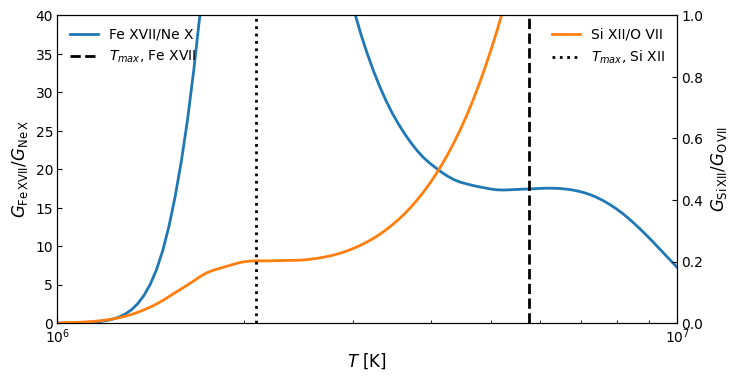

In [37]:
#| echo: false
#| warning: false
#| fig-cap: "Contribution function ratios for the two line ratio diagnostics: Fe XVII 15.01 Å/Ne X 12.13 Å ('hot') and O VII 21.60 Å/Si XII 44.16 Å ('cool'). The dashed and dotted lines denote the temperatures at which the pairs of contributions functions are at their maximum. Note that the ratios are most flat near these temperatures."
with quantity_support():
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    
    ax1.plot(temperature, goft_coronal['Fe 17']/goft_coronal['Ne 10'], color='C0', label='Fe XVII/Ne X')
    ax2.plot(temperature, goft_coronal['Si 12']/goft_coronal['O 7'], color='C1', label='Si XII/O VII')

    ax1.axvline(x=temperature[goft_coronal['Fe 17'].argmax()], color='k', ls='--',
                label=r'$T_{max}$, Fe XVII')
    ax2.axvline(x=temperature[goft_coronal['Si 12'].argmax()], color='k', ls=':',
                label=r'$T_{max}$, Si XII')

    ax1.set_xlabel(r'$T$ [K]')
    ax1.set_ylabel(r'$G_\mathrm{Fe\,XVII}/G_\mathrm{Ne\,X}$')
    ax2.set_ylabel(r'$G_\mathrm{Si\,XII}/G_\mathrm{O\,VII}$')
    ax1.set_xscale('log')
    ax1.set_ylim(0,40)
    ax2.set_ylim(0,1)
    ax1.set_xlim(1e6,1e7)
    ax1.legend(loc=2)
    ax2.legend(loc=1)
fig.savefig('rfa_figures/contribution_function_ratio.png')

## Estimating Line Intensities as Observed by MOXSI

We can compute the intensities first using an estimate of our active region DEM combined with our knowledge of the effective area and the contribution functions we've computed above.

In [10]:
#| echo: false
dem_ar = read_cube_with_xarray(
    '/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/rfa/ar_1h_coronal/dem_cube.nc',
    'temperature',
    'phys.temperature'
)
cutout = np.s_[:,170:200,165:195]
dem_cutout = dem_ar[cutout]
dem_avg = dem_cutout.rebin(
    (1,)+dem_cutout.data.shape[1:],
    operation=np.mean)[:,0,0]

In [11]:
#| echo: false
slot_o1 = copy.deepcopy(moxsi_cdr_spectrogram_slot[12])
moxsi_intensities = {}
n_rows = 100 * u.pixel # The number of rows We typically sum over for an AR
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name in selected_transitions:
        # response
        slot_o1.wavelength = np.atleast_1d(selected_transitions[name])
        ea = slot_o1.effective_area / slot_o1.energy * u.photon * slot_o1.pixel_solid_angle
        # coronal
        intensity_c = compute_intensity(temperature, goft_coronal[name], dem_avg)
        intensity_c_moxsi = intensity_c * ea * (1*u.h) * n_rows
        # photospheric
        intensity_p = compute_intensity(temperature, goft_photospheric[name], dem_avg)
        intensity_p_moxsi = intensity_p * ea * (1*u.h) * n_rows
        moxsi_intensities[name] = {
            'coronal': intensity_c_moxsi.to('ph'),
            'photospheric': intensity_p_moxsi.to('ph'),
        }

In [12]:
#| echo: false
#| label: simple-throughput-estimates
#| tbl-cap: "Estimates of MOXSI throughput for relevant spectral lines"

table = [
    [name,
     selected_transitions[name].to_value('AA'),
     moxsi_intensities[name]['coronal'].to_value('ph'),
     moxsi_intensities[name]['photospheric'].to_value('ph')]
    for name in moxsi_intensities
]
Markdown(tabulate(
  table, 
  headers=["Ion", "Wavelength [Å]", "Coronal [ph]", "Photospheric [ph]"]
))

Ion      Wavelength [Å]    Coronal [ph]    Photospheric [ph]
-----  ----------------  --------------  -------------------
Ne 10           12.1321         123.492              87.4259
Fe 17           15.0129        2042.7               478.855
O 7             21.601         1123.45              708.85
Si 12           44.16           561.971             144.449

We note that from these modeled intensity estimates we recovered the expected FIP ratios for both line pairs.

In [13]:
table[1][2] / table[0][2] / (table[1][3] / table[0][3])

array([3.01995172])

In [14]:
table[3][2] / table[2][2] / (table[3][3] / table[2][3])

array([2.45470892])

## Estimating Intensity Ratios from MOXSI Forward Model

Next, we can compute the intensity ratios from our forward modeled spectra. We model the spectra of individual elements so as to better illustrate how particular ions are observed by MOXSI without the contamination of the continuum.

In [15]:
#| echo: false
results_dir = pathlib.Path('/Users/wtbarnes/Documents/codes/mocksipipeline/pipeline/results/cdr/rfa/')

col = build_moxsi_collection(results_dir / 'ar_1h_coronal' / 'detector_images', all_components_sum=False)

idy_source, idx_source = np.unravel_index(col['spectrogram_slot_0'][0,...].data.argmax(),
                                          col['spectrogram_slot_0'][0,...].data.shape)
source_location = col['spectrogram_slot_0'][0,...].wcs.array_index_to_world(idy_source, idx_source)

cutout_slice = np.s_[:,220:320,:]

coronal_spec = {}
for el in ['fe', 'ne', 'si', 'o']:
    _col = get_1d_slot_spectra(
        build_moxsi_collection(results_dir / f'ar_1h_coronal_{el}' / 'detector_images', all_components_sum=False),
        orders=[1,],
        cutout=cutout_slice,
    )
    coronal_spec[el] = _col['spectrogram_slot_1']
coronal_spec = ndcube.NDCollection(coronal_spec)

photospheric_spec = {}
for el in ['fe', 'ne', 'si', 'o']:
    _col = get_1d_slot_spectra(
        build_moxsi_collection(results_dir / f'ar_1h_photospheric_{el}' / 'detector_images', all_components_sum=False),
        orders=[1,],
        cutout=cutout_slice,
    )
    photospheric_spec[el] = _col['spectrogram_slot_1']
photospheric_spec = ndcube.NDCollection(photospheric_spec)

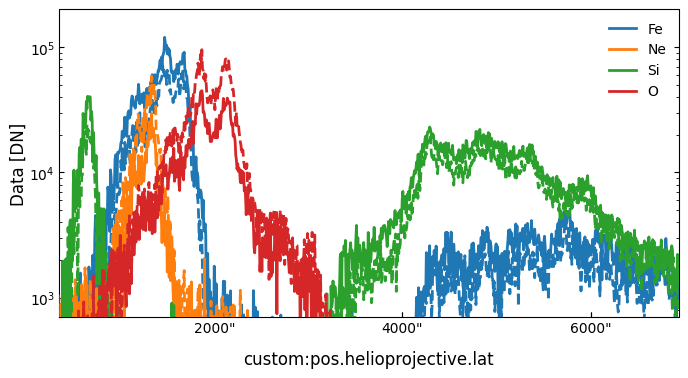

In [38]:
#| echo: false
#| fig-cap: "Modeled MOXSI spectra from an active region for the four elements of interest in the abundance ratio. The solid line shows the photospheric intensities and the solid line shows the coronal intensities."
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(projection=coronal_spec['ne'][0,...].wcs)
for i,(k,v) in enumerate(coronal_spec.items()):
    v[0,...].plot(axes=ax, label=k.capitalize(), color=f'C{i}')
    photospheric_spec[k][0,...].plot(axes=ax, color=f'C{i}', ls='--')
ax.set_xlim(1050,2000)
ax.set_ylim(7e2, 2e5)
ax.set_yscale('log')
ax.legend();
fig.savefig('rfa_figures/moxsi_spectra.png')

In [18]:
#| echo: false
intensity_coronal_fe17 = get_first_order_intensity(results_dir / 'ar_1h_coronal_fe' / 'detector_images',
                                                   source_location,
                                                   selected_transitions['Fe 17'],
                                                   cutout_slice)
intensity_coronal_ne10 = get_first_order_intensity(results_dir / 'ar_1h_coronal_ne' / 'detector_images',
                                                   source_location,
                                                   selected_transitions['Ne 10'],
                                                   cutout_slice)
intensity_photospheric_fe17 = get_first_order_intensity(results_dir / 'ar_1h_photospheric_fe' / 'detector_images',
                                                        source_location,
                                                        selected_transitions['Fe 17'],
                                                        cutout_slice)
intensity_photospheric_ne10 = get_first_order_intensity(results_dir / 'ar_1h_photospheric_ne' / 'detector_images',
                                                        source_location,
                                                        selected_transitions['Ne 10'],
                                                        cutout_slice)

The intensity ratio

$$
\frac{F(\text{Fe})}{F(\text{Ne})} = \frac{I_C(\text{Fe XVII 15.01 Å})}{I_C(\text{Ne X 12.13 Å})}\frac{I_P(\text{Ne X 12.13 Å})}{ I_P(\text{Fe XVII 15.01 Å})}
$$

can then be computed from our forward-modeled spectra.

In [19]:
(intensity_coronal_fe17 / intensity_coronal_ne10) / (intensity_photospheric_fe17 / intensity_photospheric_ne10)

<Quantity 4.42829274>

In [20]:
#| echo: false
intensity_coronal_si12 = get_first_order_intensity(results_dir / 'ar_1h_coronal_si' / 'detector_images',
                                                   source_location,
                                                   selected_transitions['Si 12'],
                                                   cutout_slice)
intensity_coronal_o7 = get_first_order_intensity(results_dir / 'ar_1h_coronal_o' / 'detector_images',
                                                 source_location,
                                                 selected_transitions['O 7'],
                                                 cutout_slice)
intensity_photospheric_si12 = get_first_order_intensity(results_dir / 'ar_1h_photospheric_si' / 'detector_images',
                                                        source_location,
                                                        selected_transitions['Si 12'],
                                                        cutout_slice)
intensity_photospheric_o7 = get_first_order_intensity(results_dir / 'ar_1h_photospheric_o' / 'detector_images',
                                                      source_location,
                                                      selected_transitions['O 7'],
                                                      cutout_slice)

Similarly, the intensity ratio

$$
\frac{F(\text{Si})}{F(\text{O)}} = \frac{I_C(\text{Si XII 44.16 Å})}{I_C(\text{O VII 21.601 Å})}\frac{I_P(\text{O VII 21.601 Å})}{ I_P(\text{Si XII 44.16 Å})}
$$

can also be computed.

In [21]:
(intensity_coronal_si12 / intensity_coronal_o7) / (intensity_photospheric_si12 / intensity_photospheric_o7)

<Quantity 2.65339067>

We find that ratios of our forward modeled MOXSI spectra at the locations of our diagostic lines for coronal and photospheric abundances are consistent with those theoretical ratios, particularly for the cool Si/O pair. **This indicates that these lines, as measured by MOXSI, have significant diagnostic power to measure changes in abundance at both hot and cool temperatures.**

We note that the Fe/Ne pair is higher than the expected theoretical result. This is likely due to the uncertainty in the line location due to the spatially-extended nature of the active region and the variable location of the hot emission within that spatial region.

## Estimating SNR in Key Diagnostic Lines

Finally, to estimate SNR in each line we require for abundance diagnsotics, we extract the intensity of each line by fitting a Lorentzian plus background at each line location in our full forward-modeled MOXSI spectra. We then use the resulting intensity (above the background) combined with the uncertainty of the fit to estimate a signal-to-noise ratio (SNR) for each diagnostic line.

First, determine an approximate initial model by fitting the zeroth order "spectra". Note that this effectively determines the spatial location and width of the active region as rebinned onto the dispersion axis.

In [32]:
#| echo: false
coronal_1d_slot = get_1d_slot_spectra(col, orders=[0,1], cutout=cutout_slice)
source_sl = coronal_1d_slot['spectrogram_slot_0'][idy_source, idx_source-50:idx_source+50]
x_data = source_sl.axis_world_coords(0)[0].Ty
y_data = u.Quantity(source_sl.data, source_sl.unit)

model_0_init = Lorentz1D(amplitude=y_data[50], x_0=x_data[50], fwhm=50*u.arcsec)
fitter = LMLSQFitter()
model_0_fit = fitter(model_0_init, x_data, y_data)

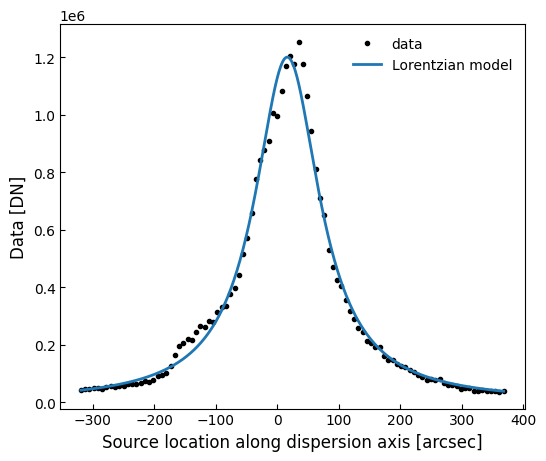

In [33]:
#| echo: false
#| fig-label: "Lorentzian model fit to the spatial envelope as defined "
x_smooth = np.linspace(*x_data[[0,-1]],1000)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()
ax.plot(x_data, y_data, color='k', marker='.', ls='', label='data')
ax.plot(x_smooth, model_0_fit(x_smooth), label='Lorentzian model')
ax.set_xlabel('Source location along dispersion axis [arcsec]')
ax.set_ylabel('Data [DN]')
ax.legend();

In [24]:
#| echo: false
model_initial = Lorentz1D(x_0=model_0_fit.x_0, fwhm=model_0_fit.fwhm/3)

We note that this spectra is modeled in photon space using an integration time of 1 h, incorporating effects due to the PSF with an accompanying 30 arcsecond pointing jitter. The effect of charge spreading is not included for this particular model.

In [25]:
#| echo: false
#| output: false
client = distributed.Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-scratch-space/worker-w6jah8o7', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-scratch-space/worker-xangtqfv', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-scratch-space/worker-w4_u9okn', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-scratch-space/worker-9cnil10i', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/dask-scratch-space/worker-ee4v68b0', purging
INFO:distributed.dis

In [27]:
#| echo: false
channel = moxsi_cdr_spectrogram_slot['spectrogram_slot_1']
spec_cube = read_data_cube(results_dir / 'ar_1h_coronal' / 'spectral_cube.fits')
instr_cube = convolve_with_response(spec_cube, channel)
pointing_jitter = 30 * u.arcsec
observer = wcs_to_celestial_frame(spec_cube.wcs).observer

In [28]:
#| echo: false
#| output: false
det_cube = project_spectral_cube(instr_cube,
                                 channel,
                                 observer,
                                 exposure=1.5*u.h,
                                 integration=1.5*u.h,
                                 pointing_jitter=pointing_jitter,
                                 include_psf=True,
                                 include_charge_spreading=False,
                                 apply_gain_conversion=False,
                                 apply_electron_conversion=False,)

coronal_1h_ar_1d_slot = det_cube[cutout_slice].rebin(
    (1, det_cube[cutout_slice].data.shape[1], 1),
    operation=np.sum
).squeeze()

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 126.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 2.37 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
  'angstrom' -> 'Angstrom'.
INFO:distributed.utils_perf:full garbage collection released 31.50 MiB from 12841 reference cycles (threshold: 9.54 MiB)


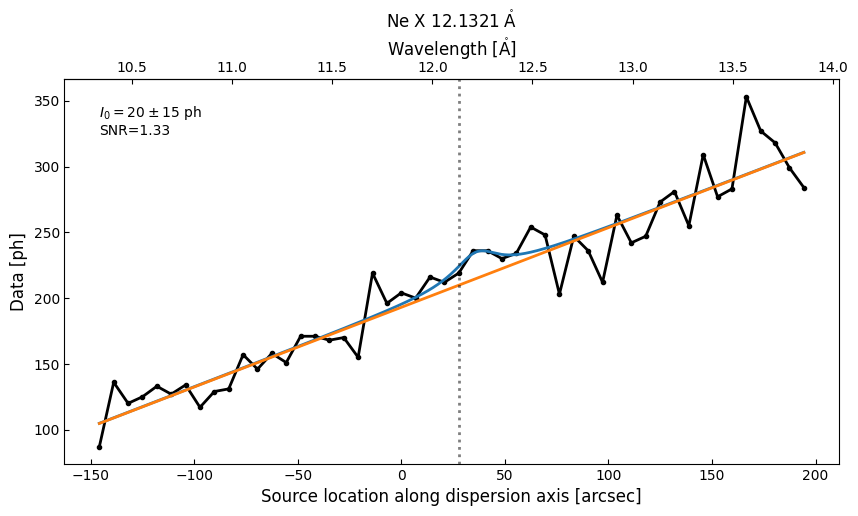

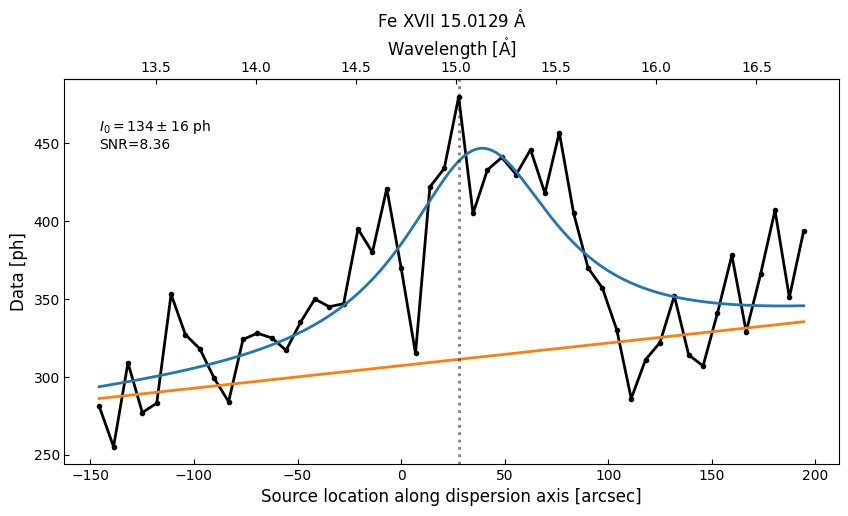

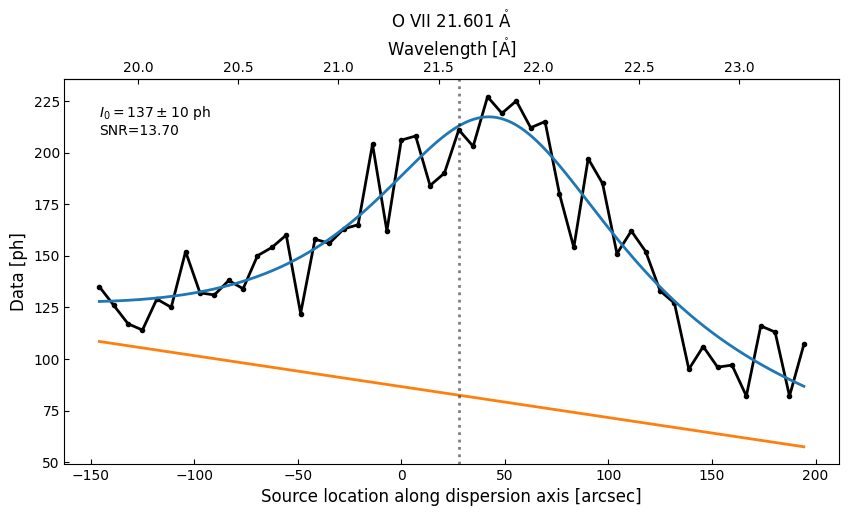

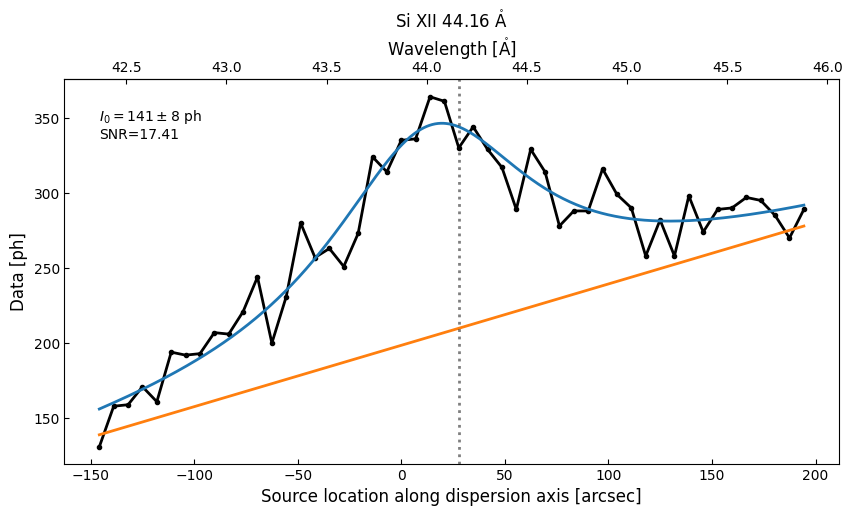

INFO:distributed.core:Event loop was unresponsive in Nanny for 61.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 61.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 61.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 61.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 61.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause ti

In [39]:
#| echo: false
#| warning: false
delta_lambda = moxsi_cdr_spectrogram_slot['spectrogram_slot_1'].spectral_plate_scale / moxsi_cdr_spectrogram_slot['spectrogram_slot_1'].spatial_plate_scale
for i,(k,v) in enumerate(selected_transitions.items()):
    x_data, y_data, model_fit = fit_spectra(coronal_1h_ar_1d_slot,
                                            source_location,
                                            v,
                                            model_initial,
                                            window=[-25,25])
    intensity_uncert = np.sqrt(model_fit.cov_matrix.cov_matrix[0,0])
    x_smooth = np.linspace(*x_data[[0,-1]], 1000)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    ax.plot(x_data, y_data, color='k', ls='-', marker='.')
    ax.plot(x_smooth, model_fit(x_smooth))
    ax.plot(x_smooth, model_fit[-1](x_smooth))
    ax.axvline(x=source_location.Ty.value, color='k', ls=':', alpha=0.5)
    snr = model_fit.amplitude_0.value / intensity_uncert
    intensity_str = f'$I_0={model_fit.amplitude_0.value:.0f}\pm{intensity_uncert:.0f}$ {model_fit.amplitude_0.unit}'
    intensity_str += '\n' + f'SNR={snr:.2f}'
    ax.text(x_data[0].value,
                 ax.get_ylim()[-1]*0.95,
                 intensity_str,
                 va='top',
                 ha='left')
    ax.set_title(f'{fiasco.base.IonBase(k).ion_name_roman} {v:latex}')
    ax_top = ax.secondary_xaxis(
        'top',
        functions=(lambda x: (x - source_location.Ty.value)*delta_lambda.value[1]+v.value,
                   lambda x: (x - v.value)/delta_lambda.value[1] + source_location.Ty.value)
    )
    ax_top.set_xlabel('Wavelength [$\mathrm{\mathring{A}}$]')
    ax.set_xlabel('Source location along dispersion axis [arcsec]')
    ax.set_ylabel('Data [ph]')
    fig.savefig(f'rfa_figures/fitted_spectra_{k}_{v}.png')
    plt.show()

We note that in all diagnostic lines but Ne X 12.13 Å, **we achieve adequate SNR as well as over 100 photons above the background** with an integration time of 1.5 hours. We intend to mitigate the lack of signal in Ne X 12.13 Å by performing more sophisticated inversions as well as exploring the use of additional high-temperature, high-FIP lines that can be used in combination with Fe XVII 15.01 Å for abundance diagnostics.